In [34]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm 
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torchinfo

from pycaleva import CalibrationEvaluator

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [3]:
def prepareData(dataGroup, id_list, window_time):
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
    elif dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):
        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")

        # 0 --> HR
        # 1 --> SpO2
        # 2 --> PAD
        # 3 --> PAM
        # 4 --> PAS
        # 5 --> RR
        # 6 --> Temperature
        # 7 --> Diuresis
        # 8 --> SpO2/FiO2
        # 9 --> FiO2
        # 10 --> ECMO flow
        
        # idx_variables_kept = [0,1,3,4,6,7]
        if dataGroup == "dataECMO":
            # idx_variables_kept = [0,1,2,3,4,5,6,7,8,9]
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]
        else:
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]

        data_patient = df_dynamic.iloc[:(window_time*24), idx_variables_kept].to_numpy()
        
        for value in df_static.to_numpy()[0]:
            new_column = np.ones(shape=(window_time*24,1)) * value
            data_patient = np.append(data_patient, new_column, axis=1)
        
        # df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)

        # # idx_variables_kept = [0,1,3,4,6,7]
        # idx_variables_kept = list(range(0,10))
        # df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        # df_dynamic = df_dynamic.iloc[:,idx_variables_kept]


        data.append(data_patient)
    
    return np.array(data)


def prepareDeathList(dataGroup, window_time):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        patients_df = pd.read_csv(dataPath + "ventiles.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])

            df_mask = pd.read_parquet(dataPath + "finalData/" + stay_id + "/mask.parquet")
            total_true_values = df_mask.values.sum()
            total_values = df_mask.values.size
            percentageMissingValues = (total_values-total_true_values)/total_values * 100

            if percentageMissingValues < 40:
                id_list.append(stay_id)
                
                label_death = int(row["label"])
                target.append(label_death)
            
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    elif dataGroup == "dataRangueil":
        dataPath = "../dataRea/"

    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            id_list.append(encounterId)
            
            delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
            if delai_sortie_deces <= 1:
                target.append(1)
            else:
                target.append(0)
    
    return target, id_list

In [4]:
target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO = prepareData("dataECMO", id_list_ECMO, window_time=5)

print(f"ECMO dataset size: {len(target_ECMO)} , num_deceased: {np.sum(target_ECMO)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 162.26it/s]

ECMO dataset size: 153 , num_deceased: 55


In [5]:
target_Rangueil, id_list_Rangueil =  prepareDeathList("dataRangueil", window_time=5)
data_Rangueil = prepareData("dataRangueil", id_list_Rangueil, window_time=5)

print(f"Rea dataset size: {len(target_Rangueil)} , num_deceased: {np.sum(target_Rangueil)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1697/1697 [00:10<00:00, 163.11it/s]


Rea dataset size: 1697 , num_deceased: 445


In [6]:
target_Mimic, id_list_Mimic = prepareDeathList("dataMimic", window_time=5)
data_Mimic = prepareData("dataMimic", id_list_Mimic, window_time=5)

print(f"Mimic dataset size: {len(target_Mimic)} , num_deceased: {np.sum(target_Mimic)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4140/4140 [00:24<00:00, 166.02it/s]

Mimic dataset size: 4140 , num_deceased: 1049


In [7]:
target_MR = target_Mimic + target_Rangueil
id_list = id_list_Mimic + id_list_Rangueil

data_MR = np.concatenate((data_Mimic,data_Rangueil),axis=0)

print(f"dataset size mimic+rea: {len(target_MR)} , num_deceased: {np.sum(target_MR)}")

dataset size mimic+rea: 5837 , num_deceased: 1494


In [8]:
from typing import cast, Union, List
import torch.nn.functional as F

class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)



class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939

    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

In [35]:
def train_model(data, target, test_fold, validation_activated, test_activated, num_epochs, model_name, verbose, save_path, save_model, plot_train_curves, load_model_path=None):

    
    num_samples = len(target)
    K = 10
    sub_samples_size = num_samples//K
    
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,9)
        while val_fold == test_fold:
            val_fold = random.randint(0,9)
    else:
        val_fold = None
    
    x_train = np.empty((0,np.shape(data)[1], np.shape(data)[2]))
    y_train = []
    x_test = []
    y_test = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            x_train = np.concatenate((x_train, current_data_fold))
            y_train = y_train + current_target_fold

    
    num_timesteps = np.size(x_train,1)
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static

    
    batch_size = 32

    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)


    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = InceptionModel(num_blocks=1, 
                           in_channels=12, 
                           out_channels=8,
                           bottleneck_channels=2, 
                           kernel_sizes=41, 
                           use_residuals=True, 
                           num_pred_classes=1)

    if load_model_path != None:
        state_dict = torch.load(load_model_path)
        model.load_state_dict(state_dict)

    # criterion = nn.BCELoss()  # Binary cross-entropy loss

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    optimizer = optim.Adam(model.parameters())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_auroc = 0
    best_model_state = None
    val_auroc_list = []
    train_auroc_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        predictions = []
        true_labels = []
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            prediction = nn.functional.sigmoid(outputs).detach()
            predictions.extend(prediction.cpu().numpy())
            
            true_labels.extend(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_auroc = roc_auc_score(true_labels, predictions)
        train_auroc_list.append(train_auroc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Train AUROC: {train_auroc:.4f}")

        # Validation
        if validation_activated:
            model.eval()
            val_loss = 0.0

            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.permute(0, 2, 1)

                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

                    prediction = nn.functional.sigmoid(outputs)
                    predictions.extend(prediction.cpu().numpy())

                    true_labels.extend(labels.cpu().numpy())
                    
        
            val_auroc = roc_auc_score(true_labels, predictions)
            val_auroc_list.append(val_auroc) 
            if verbose:
                print(f"Validation Loss: {val_loss:.4f}, Validation AUROC: {val_auroc:.4f}")

            if val_auroc > best_val_auroc:
            # if val_auroc > best_val_auroc and val_auroc < train_auroc:
                best_val_auroc = val_auroc
                best_model_state = model.state_dict()
                torch.save(model.state_dict(), save_path)
            

    if validation_activated:
        if best_val_auroc > 0:
            state_dict = torch.load(save_path)
            model.load_state_dict(state_dict)

        if plot_train_curves:
            plt.figure(figsize=(5, 3))

            plt.plot(range(num_epochs), train_auroc_list, label='Train AUROC', color='blue')
            plt.plot(range(num_epochs), val_auroc_list, label='Validation AUROC', color='red')

            plt.xlabel('epochs')
            plt.ylabel('auroc')
            plt.title('Train and Val AUROC = f(epoch)')

            plt.legend()

            plt.show()

    if test_activated:
        model.eval()
    
        auroc, precision, recall, tnr, f1, accuracy = 0,0,0,0,0,0 
    
        true_labels = []
        predictions = []
        predictions_binary = []
    
        treshold = 0.5
    
        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        with torch.no_grad():
            for inputs, labels in test_loader:
    
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1)
                
                true_labels.extend(labels.cpu().numpy())
    
                outputs = nn.functional.sigmoid(model(inputs)).cpu().numpy()
                predictions.extend(outputs)
                predictions_binary.extend((outputs > treshold).astype(int))
    
                for k in range(len(outputs)):
                    pred = outputs[k][0]
                    group = int(pred * 10)
                    group = min(group,9)
                    HL_num_groups[group] +=1
                    HL_pred_groups[group] += pred
                    if labels[k] > 0.5:
                        HL_true_groups[group] += 1
                
            # print(np.round(np.array([p[0] for p in predictions]), 1))
        
        plt.figure(figsize=(5, 3))

        plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
        plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

        plt.xlabel('predicted mortality')
        plt.ylabel('hospital mortality')
        plt.title('Hosmer-Lemeshow Test')

        plt.legend()

        plt.show()
        HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))
        
        ce = CalibrationEvaluator(true_labels, np.array(predictions).squeeze(), outsample=True, n_groups='auto')
        ce.hosmerlemeshow()
        
        auroc = roc_auc_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions_binary, zero_division=0)
        recall = recall_score(true_labels, predictions_binary, zero_division=0)
        tnr = tnr_score(true_labels, predictions_binary)
        f1 = f1_score(true_labels, predictions_binary, zero_division=0)
        accuracy = accuracy_score(true_labels, predictions_binary)
    
    # if verbose:
    # print("Test AUROC score:", auroc)

        return auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, best_model_state
    # else:
    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

Epoch 1/75, Train loss: 178.8105, Train AUROC: 0.5766
Validation Loss: 22.1413, Validation AUROC: 0.6160
Epoch 2/75, Train loss: 166.1600, Train AUROC: 0.6569
Validation Loss: 21.3609, Validation AUROC: 0.6685
Epoch 3/75, Train loss: 162.4680, Train AUROC: 0.6820
Validation Loss: 21.1254, Validation AUROC: 0.6842
Epoch 4/75, Train loss: 160.8778, Train AUROC: 0.6913
Validation Loss: 20.9262, Validation AUROC: 0.6960
Epoch 5/75, Train loss: 159.5876, Train AUROC: 0.6990
Validation Loss: 20.7432, Validation AUROC: 0.7054
Epoch 6/75, Train loss: 158.2594, Train AUROC: 0.7066
Validation Loss: 20.6038, Validation AUROC: 0.7120
Epoch 7/75, Train loss: 156.9513, Train AUROC: 0.7131
Validation Loss: 20.5230, Validation AUROC: 0.7140
Epoch 8/75, Train loss: 156.2772, Train AUROC: 0.7188
Validation Loss: 20.4871, Validation AUROC: 0.7142
Epoch 9/75, Train loss: 155.6639, Train AUROC: 0.7224
Validation Loss: 20.4507, Validation AUROC: 0.7153
Epoch 10/75, Train loss: 155.0869, Train AUROC: 0.7248


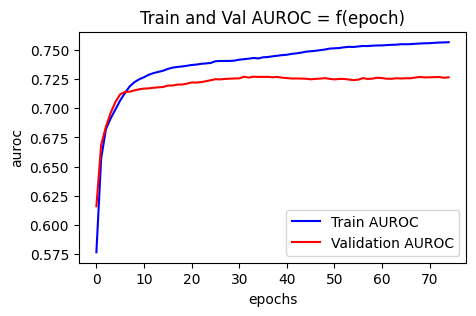

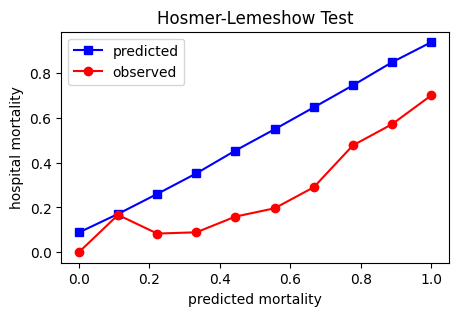

,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.0856, 0.291]",53,0.227262,0.094340,5.000000,12.044907
1,"(0.291, 0.352]",53,0.322596,0.075472,4.000000,17.097605
2,"(0.352, 0.411]",53,0.378862,0.094340,5.000000,20.079664
3,"(0.411, 0.474]",53,0.443029,0.113208,6.000000,23.480513
4,"(0.474, 0.523]",53,0.498807,0.207547,11.000000,26.436754
5,"(0.523, 0.574]",53,0.549345,0.226415,12.000000,29.115313
6,"(0.574, 0.622]",53,0.601166,0.169811,9.000000,31.861788
7,"(0.622, 0.678]",53,0.649869,0.377358,20.000000,34.443047
8,"(0.678, 0.745]",53,0.712709,0.358491,19.000000,37.773575
9,"(0.745, 0.838]",53,0.789589,0.566038,30.000000,41.848202



 10%|███████████████▉                                                                                                                                               | 1/10 [00:41<06:09, 41.05s/it]

C(11): 250.89 p-value: < 0.001
test AUROC: 0.7512
test Precision: 0.3673
test Recall: 0.8182
test Specificity: 0.4117
test Accuracy: 0.5798
test F1 Score: 0.5070
test HL Score: 44.9248
Epoch 1/75, Train loss: 166.7877, Train AUROC: 0.6325
Validation Loss: 22.0719, Validation AUROC: 0.6286
Epoch 2/75, Train loss: 161.7494, Train AUROC: 0.6766
Validation Loss: 21.7296, Validation AUROC: 0.6494
Epoch 3/75, Train loss: 159.7002, Train AUROC: 0.6911
Validation Loss: 21.5949, Validation AUROC: 0.6594
Epoch 4/75, Train loss: 158.0733, Train AUROC: 0.7016
Validation Loss: 21.4260, Validation AUROC: 0.6665
Epoch 5/75, Train loss: 156.3973, Train AUROC: 0.7122
Validation Loss: 21.3962, Validation AUROC: 0.6729
Epoch 6/75, Train loss: 155.1835, Train AUROC: 0.7198
Validation Loss: 21.2330, Validation AUROC: 0.6779
Epoch 7/75, Train loss: 154.3069, Train AUROC: 0.7244
Validation Loss: 21.0963, Validation AUROC: 0.6830
Epoch 8/75, Train loss: 153.6853, Train AUROC: 0.7273
Validation Loss: 21.0350, 

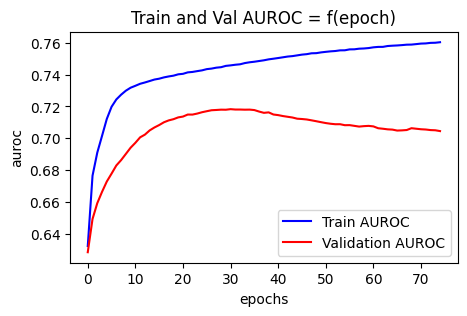

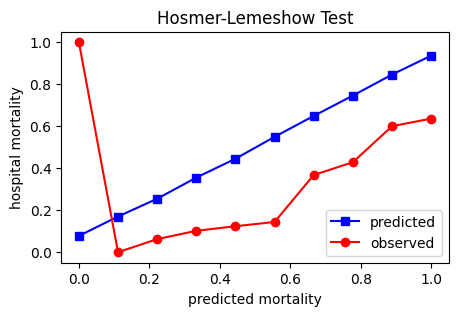

,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.0767, 0.266]",53,0.208372,0.056604,3.000000,11.043719
1,"(0.266, 0.335]",53,0.299434,0.094340,5.000000,15.869994
2,"(0.335, 0.38]",53,0.357767,0.113208,6.000000,18.961664
3,"(0.38, 0.421]",53,0.404098,0.150943,8.000000,21.417177
4,"(0.421, 0.484]",53,0.454433,0.056604,3.000000,24.084938
5,"(0.484, 0.538]",53,0.514041,0.150943,8.000000,27.244158
6,"(0.538, 0.583]",53,0.558401,0.150943,8.000000,29.595236
7,"(0.583, 0.638]",53,0.610771,0.207547,11.000000,32.370861
8,"(0.638, 0.702]",53,0.671095,0.433962,23.000000,35.568012
9,"(0.702, 0.795]",53,0.746702,0.433962,23.000000,39.575195



 20%|███████████████████████████████▊                                                                                                                               | 2/10 [01:21<05:26, 40.84s/it]

C(11): 255.05 p-value: < 0.001
test AUROC: 0.7586
test Precision: 0.3399
test Recall: 0.7939
test Specificity: 0.4751
test Accuracy: 0.6072
test F1 Score: 0.4760
test HL Score: 64.3729
Epoch 1/75, Train loss: 171.0171, Train AUROC: 0.6292
Validation Loss: 20.2808, Validation AUROC: 0.6823
Epoch 2/75, Train loss: 164.4618, Train AUROC: 0.6644
Validation Loss: 20.2078, Validation AUROC: 0.6960
Epoch 3/75, Train loss: 162.0753, Train AUROC: 0.6803
Validation Loss: 20.1301, Validation AUROC: 0.7028
Epoch 4/75, Train loss: 160.4779, Train AUROC: 0.6908
Validation Loss: 20.0241, Validation AUROC: 0.7055
Epoch 5/75, Train loss: 158.9936, Train AUROC: 0.7006
Validation Loss: 19.8258, Validation AUROC: 0.7113
Epoch 6/75, Train loss: 157.6087, Train AUROC: 0.7092
Validation Loss: 19.6061, Validation AUROC: 0.7167
Epoch 7/75, Train loss: 156.5587, Train AUROC: 0.7145
Validation Loss: 19.4413, Validation AUROC: 0.7203
Epoch 8/75, Train loss: 155.7513, Train AUROC: 0.7188
Validation Loss: 19.1508, 

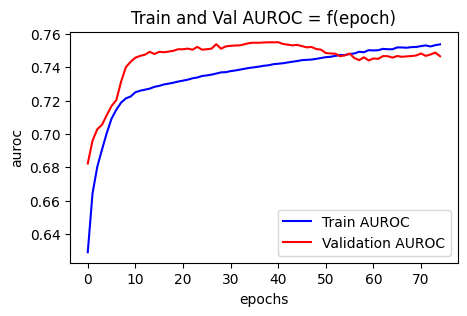

/tmp/ipykernel_34993/2167504065.py:223: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34993/2167504065.py:224: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


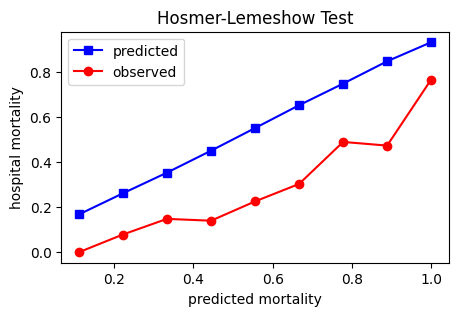

/tmp/ipykernel_34993/2167504065.py:233: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))


,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.111, 0.288]",53,0.230842,0.056604,3.000000,12.234611
1,"(0.288, 0.351]",53,0.319045,0.132075,7.000000,16.909399
2,"(0.351, 0.415]",53,0.381088,0.188679,10.000000,20.197653
3,"(0.415, 0.464]",53,0.438947,0.113208,6.000000,23.264179
4,"(0.464, 0.521]",53,0.497728,0.132075,7.000000,26.379589
5,"(0.521, 0.568]",53,0.542936,0.226415,12.000000,28.775589
6,"(0.568, 0.614]",53,0.589706,0.226415,12.000000,31.254400
7,"(0.614, 0.682]",53,0.647236,0.301887,16.000000,34.303497
8,"(0.682, 0.734]",53,0.706554,0.396226,21.000000,37.447376
9,"(0.734, 0.8]",53,0.764914,0.566038,30.000000,40.540428



 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [02:02<04:44, 40.70s/it]

C(11): 236.18 p-value: < 0.001
test AUROC: 0.7327
test Precision: 0.3623
test Recall: 0.8117
test Specificity: 0.4082
test Accuracy: 0.5729
test F1 Score: 0.5010
test HL Score: nan
Epoch 1/75, Train loss: 167.1219, Train AUROC: 0.6327
Validation Loss: 19.8806, Validation AUROC: 0.6824
Epoch 2/75, Train loss: 160.4779, Train AUROC: 0.6890
Validation Loss: 19.6909, Validation AUROC: 0.6980
Epoch 3/75, Train loss: 158.9789, Train AUROC: 0.6986
Validation Loss: 19.5330, Validation AUROC: 0.7090
Epoch 4/75, Train loss: 157.8892, Train AUROC: 0.7048
Validation Loss: 19.4455, Validation AUROC: 0.7133
Epoch 5/75, Train loss: 157.0285, Train AUROC: 0.7095
Validation Loss: 19.4005, Validation AUROC: 0.7163
Epoch 6/75, Train loss: 156.3993, Train AUROC: 0.7130
Validation Loss: 19.3131, Validation AUROC: 0.7206
Epoch 7/75, Train loss: 155.8675, Train AUROC: 0.7161
Validation Loss: 19.2616, Validation AUROC: 0.7239
Epoch 8/75, Train loss: 155.3552, Train AUROC: 0.7189
Validation Loss: 19.2752, Vali

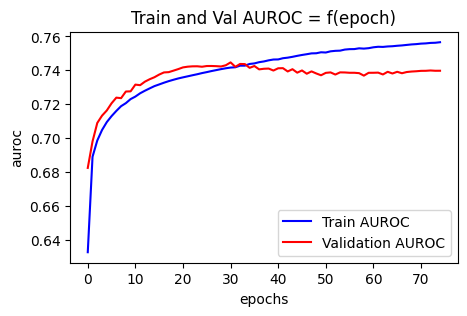

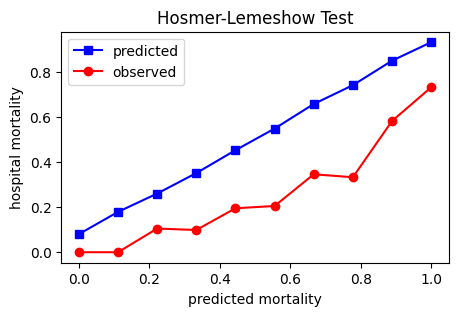

,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.0794, 0.283]",53,0.237752,0.094340,5.000000,12.600881
1,"(0.283, 0.352]",53,0.318085,0.113208,6.000000,16.858479
2,"(0.352, 0.418]",53,0.383506,0.075472,4.000000,20.325808
3,"(0.418, 0.48]",53,0.449217,0.169811,9.000000,23.808512
4,"(0.48, 0.528]",53,0.504285,0.207547,11.000000,26.727129
5,"(0.528, 0.582]",53,0.551382,0.245283,13.000000,29.223267
6,"(0.582, 0.641]",53,0.609223,0.283019,15.000000,32.288822
7,"(0.641, 0.69]",53,0.667544,0.339623,18.000000,35.379837
8,"(0.69, 0.733]",53,0.709372,0.339623,18.000000,37.596722
9,"(0.733, 0.828]",53,0.772819,0.358491,19.000000,40.959423



 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [02:42<04:03, 40.60s/it]

C(11): 254.50 p-value: < 0.001
test AUROC: 0.7126
test Precision: 0.3496
test Recall: 0.7974
test Specificity: 0.4014
test Accuracy: 0.5575
test F1 Score: 0.4861
test HL Score: 42.3618
Epoch 1/75, Train loss: 167.0103, Train AUROC: 0.6414
Validation Loss: 20.8174, Validation AUROC: 0.6636
Epoch 2/75, Train loss: 162.1897, Train AUROC: 0.6836
Validation Loss: 20.5084, Validation AUROC: 0.6705
Epoch 3/75, Train loss: 160.0914, Train AUROC: 0.6983
Validation Loss: 20.3205, Validation AUROC: 0.6801
Epoch 4/75, Train loss: 158.4624, Train AUROC: 0.7085
Validation Loss: 20.1907, Validation AUROC: 0.6876
Epoch 5/75, Train loss: 157.2275, Train AUROC: 0.7151
Validation Loss: 20.1096, Validation AUROC: 0.6934
Epoch 6/75, Train loss: 156.4374, Train AUROC: 0.7187
Validation Loss: 20.0021, Validation AUROC: 0.6991
Epoch 7/75, Train loss: 155.8691, Train AUROC: 0.7213
Validation Loss: 19.9182, Validation AUROC: 0.7037
Epoch 8/75, Train loss: 155.3016, Train AUROC: 0.7238
Validation Loss: 19.8739, 

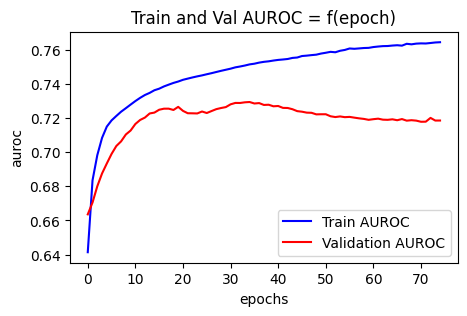

/tmp/ipykernel_34993/2167504065.py:223: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34993/2167504065.py:224: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


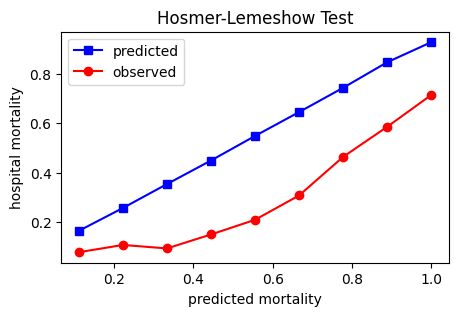

/tmp/ipykernel_34993/2167504065.py:233: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))


,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.124, 0.292]",53,0.228453,0.094340,5.000000,12.108014
1,"(0.292, 0.376]",53,0.333454,0.113208,6.000000,17.673075
2,"(0.376, 0.435]",53,0.406515,0.075472,4.000000,21.545296
3,"(0.435, 0.496]",53,0.462501,0.169811,9.000000,24.512529
4,"(0.496, 0.537]",53,0.514917,0.150943,8.000000,27.290606
5,"(0.537, 0.58]",53,0.559509,0.245283,13.000000,29.653992
6,"(0.58, 0.622]",53,0.601506,0.358491,19.000000,31.879835
7,"(0.622, 0.673]",53,0.643800,0.207547,11.000000,34.121391
8,"(0.673, 0.72]",53,0.696959,0.396226,21.000000,36.938805
9,"(0.72, 0.788]",53,0.754312,0.471698,25.000000,39.978523



 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [03:21<03:20, 40.06s/it]

C(11): 237.38 p-value: < 0.001
test AUROC: 0.7276
test Precision: 0.3489
test Recall: 0.8301
test Specificity: 0.3756
test Accuracy: 0.5489
test F1 Score: 0.4913
test HL Score: nan
Epoch 1/75, Train loss: 166.7541, Train AUROC: 0.6418
Validation Loss: 21.1390, Validation AUROC: 0.6824
Epoch 2/75, Train loss: 162.5935, Train AUROC: 0.6797
Validation Loss: 20.9477, Validation AUROC: 0.6926
Epoch 3/75, Train loss: 160.9097, Train AUROC: 0.6914
Validation Loss: 20.8736, Validation AUROC: 0.6958
Epoch 4/75, Train loss: 159.7636, Train AUROC: 0.6982
Validation Loss: 20.7791, Validation AUROC: 0.6995
Epoch 5/75, Train loss: 158.8184, Train AUROC: 0.7036
Validation Loss: 20.6714, Validation AUROC: 0.7035
Epoch 6/75, Train loss: 157.8581, Train AUROC: 0.7103
Validation Loss: 20.5421, Validation AUROC: 0.7085
Epoch 7/75, Train loss: 156.9106, Train AUROC: 0.7135
Validation Loss: 20.5579, Validation AUROC: 0.7058
Epoch 8/75, Train loss: 156.4248, Train AUROC: 0.7157
Validation Loss: 20.4486, Vali

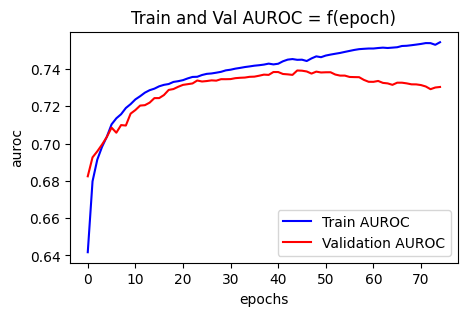

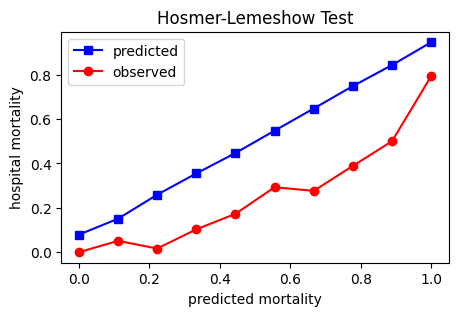

,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.06709999999999999, 0.226]",53,0.154896,0.037736,2.000000,8.209479
1,"(0.226, 0.304]",53,0.268324,0.018868,1.000000,14.221158
2,"(0.304, 0.361]",53,0.335981,0.037736,2.000000,17.806976
3,"(0.361, 0.411]",53,0.385734,0.169811,9.000000,20.443876
4,"(0.411, 0.476]",53,0.442695,0.169811,9.000000,23.462837
5,"(0.476, 0.541]",53,0.509885,0.226415,12.000000,27.023899
6,"(0.541, 0.614]",53,0.573603,0.339623,18.000000,30.400963
7,"(0.614, 0.672]",53,0.641195,0.320755,17.000000,33.983345
8,"(0.672, 0.746]",53,0.712544,0.283019,15.000000,37.764809
9,"(0.746, 0.831]",53,0.787584,0.452830,24.000000,41.741940



 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [04:01<02:39, 39.94s/it]

C(11): 245.17 p-value: < 0.001
test AUROC: 0.7751
test Precision: 0.3887
test Recall: 0.8125
test Specificity: 0.4837
test Accuracy: 0.6381
test F1 Score: 0.5258
test HL Score: 45.5156
Epoch 1/75, Train loss: 164.8527, Train AUROC: 0.6592
Validation Loss: 22.0681, Validation AUROC: 0.6227
Epoch 2/75, Train loss: 160.6314, Train AUROC: 0.6881
Validation Loss: 22.0397, Validation AUROC: 0.6374
Epoch 3/75, Train loss: 159.2308, Train AUROC: 0.6974
Validation Loss: 21.9270, Validation AUROC: 0.6481
Epoch 4/75, Train loss: 158.1415, Train AUROC: 0.7045
Validation Loss: 21.8161, Validation AUROC: 0.6562
Epoch 5/75, Train loss: 157.0548, Train AUROC: 0.7114
Validation Loss: 21.6952, Validation AUROC: 0.6624
Epoch 6/75, Train loss: 155.9374, Train AUROC: 0.7184
Validation Loss: 21.5765, Validation AUROC: 0.6695
Epoch 7/75, Train loss: 154.8359, Train AUROC: 0.7242
Validation Loss: 21.4607, Validation AUROC: 0.6757
Epoch 8/75, Train loss: 153.8576, Train AUROC: 0.7291
Validation Loss: 21.4128, 

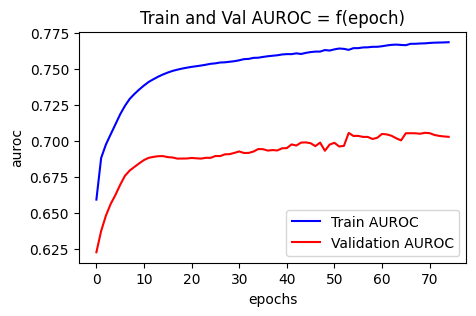

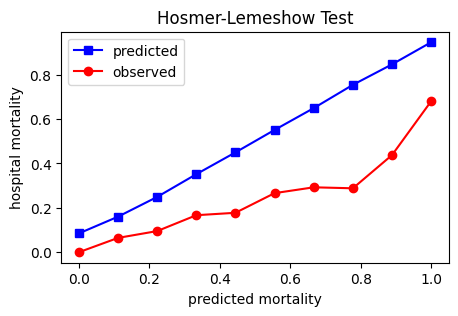

,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.0611, 0.227]",53,0.175965,0.094340,5.000000,9.326118
1,"(0.227, 0.321]",53,0.271171,0.094340,5.000000,14.372080
2,"(0.321, 0.389]",53,0.355211,0.169811,9.000000,18.826170
3,"(0.389, 0.452]",53,0.420016,0.113208,6.000000,22.260838
4,"(0.452, 0.495]",53,0.470318,0.226415,12.000000,24.926874
5,"(0.495, 0.546]",53,0.521057,0.169811,9.000000,27.616028
6,"(0.546, 0.593]",53,0.568431,0.301887,16.000000,30.126831
7,"(0.593, 0.663]",53,0.630340,0.301887,16.000000,33.408024
8,"(0.663, 0.754]",53,0.709691,0.301887,16.000000,37.613602
9,"(0.754, 0.834]",53,0.794259,0.339623,18.000000,42.095722



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [04:42<02:01, 40.37s/it]

C(11): 288.54 p-value: < 0.001
test AUROC: 0.6913
test Precision: 0.3355
test Recall: 0.7343
test Specificity: 0.4631
test Accuracy: 0.5780
test F1 Score: 0.4605
test HL Score: 37.9783
Epoch 1/75, Train loss: 167.1627, Train AUROC: 0.6371
Validation Loss: 20.0705, Validation AUROC: 0.7195
Epoch 2/75, Train loss: 162.4880, Train AUROC: 0.6769
Validation Loss: 19.8477, Validation AUROC: 0.7317
Epoch 3/75, Train loss: 160.2541, Train AUROC: 0.6929
Validation Loss: 19.5783, Validation AUROC: 0.7452
Epoch 4/75, Train loss: 157.9036, Train AUROC: 0.7075
Validation Loss: 19.2270, Validation AUROC: 0.7630
Epoch 5/75, Train loss: 156.3615, Train AUROC: 0.7159
Validation Loss: 19.1587, Validation AUROC: 0.7662
Epoch 6/75, Train loss: 155.4142, Train AUROC: 0.7211
Validation Loss: 19.1707, Validation AUROC: 0.7667
Epoch 7/75, Train loss: 154.7816, Train AUROC: 0.7243
Validation Loss: 19.2713, Validation AUROC: 0.7652
Epoch 8/75, Train loss: 154.3291, Train AUROC: 0.7263
Validation Loss: 19.3134, 

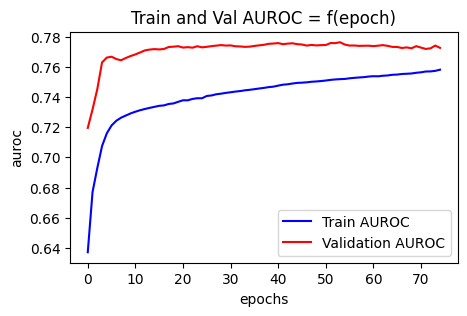

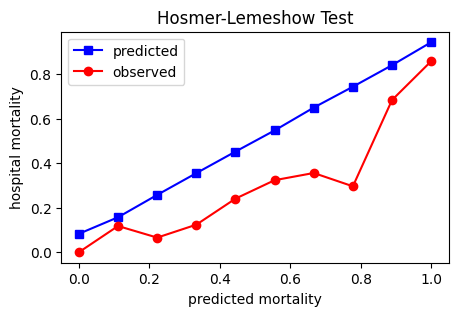

,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.0653, 0.266]",53,0.197904,0.075472,4.000000,10.488936
1,"(0.266, 0.336]",53,0.299073,0.094340,5.000000,15.850853
2,"(0.336, 0.389]",53,0.362182,0.075472,4.000000,19.195627
3,"(0.389, 0.444]",53,0.418990,0.188679,10.000000,22.206484
4,"(0.444, 0.487]",53,0.463753,0.283019,15.000000,24.578892
5,"(0.487, 0.538]",53,0.512067,0.301887,16.000000,27.139559
6,"(0.538, 0.598]",53,0.567682,0.358491,19.000000,30.087156
7,"(0.598, 0.653]",53,0.625979,0.358491,19.000000,33.176880
8,"(0.653, 0.709]",53,0.683074,0.320755,17.000000,36.202923
9,"(0.709, 0.794]",53,0.746820,0.301887,16.000000,39.581436



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [05:24<01:21, 40.64s/it]

C(11): 187.52 p-value: < 0.001
test AUROC: 0.7086
test Precision: 0.3864
test Recall: 0.7391
test Specificity: 0.4717
test Accuracy: 0.6038
test F1 Score: 0.5075
test HL Score: 34.5992
Epoch 1/75, Train loss: 167.5282, Train AUROC: 0.6369
Validation Loss: 21.6472, Validation AUROC: 0.6734
Epoch 2/75, Train loss: 163.2559, Train AUROC: 0.6734
Validation Loss: 21.4000, Validation AUROC: 0.6847
Epoch 3/75, Train loss: 162.0674, Train AUROC: 0.6818
Validation Loss: 21.3301, Validation AUROC: 0.6884
Epoch 4/75, Train loss: 161.2154, Train AUROC: 0.6876
Validation Loss: 21.2585, Validation AUROC: 0.6915
Epoch 5/75, Train loss: 160.4571, Train AUROC: 0.6921
Validation Loss: 21.2214, Validation AUROC: 0.6933
Epoch 6/75, Train loss: 159.6577, Train AUROC: 0.6968
Validation Loss: 21.1659, Validation AUROC: 0.6968
Epoch 7/75, Train loss: 158.8024, Train AUROC: 0.7018
Validation Loss: 21.1334, Validation AUROC: 0.6986
Epoch 8/75, Train loss: 157.9794, Train AUROC: 0.7065
Validation Loss: 21.1171, 

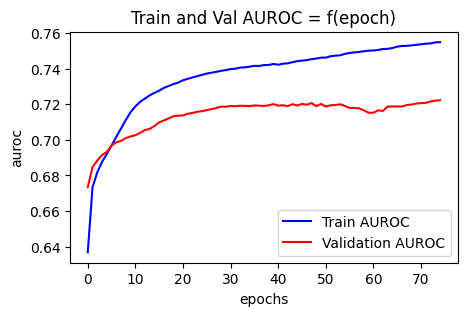

/tmp/ipykernel_34993/2167504065.py:223: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34993/2167504065.py:224: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


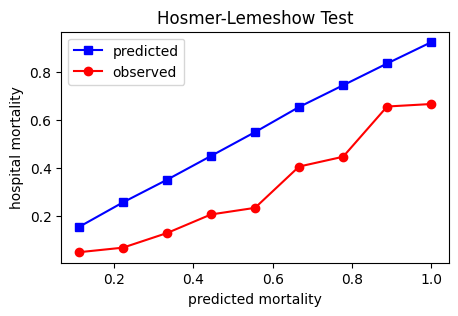

/tmp/ipykernel_34993/2167504065.py:233: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))


,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.099, 0.278]",53,0.207045,0.056604,3.000000,10.973381
1,"(0.278, 0.342]",53,0.313932,0.094340,5.000000,16.638414
2,"(0.342, 0.399]",53,0.370467,0.150943,8.000000,19.634737
3,"(0.399, 0.446]",53,0.424380,0.207547,11.000000,22.492157
4,"(0.446, 0.495]",53,0.467738,0.226415,12.000000,24.790112
5,"(0.495, 0.547]",53,0.520913,0.188679,10.000000,27.608364
6,"(0.547, 0.592]",53,0.567515,0.226415,12.000000,30.078297
7,"(0.592, 0.648]",53,0.624550,0.358491,19.000000,33.101124
8,"(0.648, 0.694]",53,0.672100,0.452830,24.000000,35.621323
9,"(0.694, 0.773]",53,0.727941,0.396226,21.000000,38.580864



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [06:05<00:40, 40.81s/it]

C(11): 170.88 p-value: < 0.001
test AUROC: 0.7301
test Precision: 0.3891
test Recall: 0.7562
test Specificity: 0.4666
test Accuracy: 0.6072
test F1 Score: 0.5138
test HL Score: nan
Epoch 1/75, Train loss: 169.3465, Train AUROC: 0.6192
Validation Loss: 22.0375, Validation AUROC: 0.6372
Epoch 2/75, Train loss: 163.2711, Train AUROC: 0.6750
Validation Loss: 21.7694, Validation AUROC: 0.6568
Epoch 3/75, Train loss: 161.1669, Train AUROC: 0.6901
Validation Loss: 21.6149, Validation AUROC: 0.6662
Epoch 4/75, Train loss: 159.7289, Train AUROC: 0.6998
Validation Loss: 21.5557, Validation AUROC: 0.6712
Epoch 5/75, Train loss: 158.1476, Train AUROC: 0.7088
Validation Loss: 21.4146, Validation AUROC: 0.6782
Epoch 6/75, Train loss: 156.5531, Train AUROC: 0.7173
Validation Loss: 21.3441, Validation AUROC: 0.6814
Epoch 7/75, Train loss: 155.2474, Train AUROC: 0.7239
Validation Loss: 21.2904, Validation AUROC: 0.6835
Epoch 8/75, Train loss: 154.1942, Train AUROC: 0.7289
Validation Loss: 21.2282, Vali

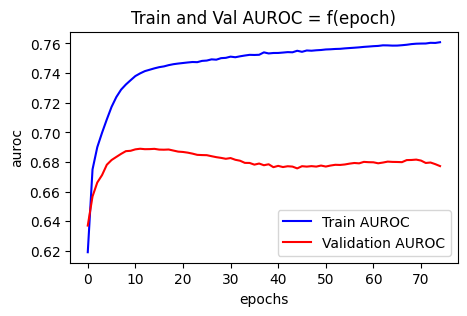

/tmp/ipykernel_34993/2167504065.py:223: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34993/2167504065.py:224: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


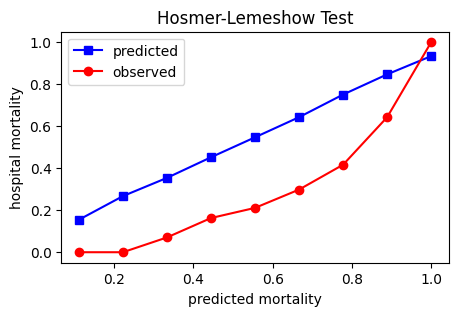

/tmp/ipykernel_34993/2167504065.py:233: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))


,Interval,total,mean_predicted,mean_observed,observed_1,predicted_1
0,"(0.133, 0.35]",54,0.298532,0.055556,3.000000,16.120701
1,"(0.35, 0.415]",54,0.382205,0.111111,6.000000,20.639093
2,"(0.415, 0.455]",53,0.434852,0.113208,6.000000,23.047144
3,"(0.455, 0.493]",54,0.474238,0.129630,7.000000,25.608852
4,"(0.493, 0.527]",53,0.511209,0.169811,9.000000,27.094084
5,"(0.527, 0.557]",54,0.538675,0.277778,15.000000,29.088440
6,"(0.557, 0.592]",53,0.576359,0.245283,13.000000,30.547035
7,"(0.592, 0.63]",54,0.611624,0.259259,14.000000,33.027714
8,"(0.63, 0.685]",53,0.652352,0.283019,15.000000,34.574677
9,"(0.685, 0.771]",54,0.720366,0.388889,21.000000,38.899742



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:46<00:00, 406.39s/it]

C(11): 253.70 p-value: < 0.001
test AUROC: 0.7135
test Precision: 0.3134
test Recall: 0.8156
test Specificity: 0.3780
test Accuracy: 0.5288
test F1 Score: 0.4528
test HL Score: nan
Mean AUROC: 0.7301
Mean Precision: 0.3581
Mean Recall: 0.7909
Mean Specificity: 0.4335
Mean Accuracy: 0.5822
Mean F1 Score: 0.4922
SD Auroc: 0.0242
Total Mean AUROC: 0.7301
Total Mean Precision: 0.3581
Total Mean Recall: 0.7909
Total Mean Specificity: 0.4335
Total Mean Accuracy: 0.5822
Total Mean F1 Score: 0.4922


In [37]:
num_train = 1
K = 10

save_path = "saved_models/test.pth"
load_path = "saved_models/cnn_1d_76_76.pth"


best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_mean = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []   

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []    
    
    for j in tqdm(range(10)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, state_dict  =  train_model(data=data_MR,
                                                                                    target=target_MR,
                                                                                    test_fold = j,
                                                                                    validation_activated=True,
                                                                                    test_activated = True,
                                                                                    num_epochs=75, 
                                                                                    model_name="InceptionTime",
                                                                                    verbose=True, 
                                                                                    save_path=save_path, 
                                                                                    save_model=True, 
                                                                                    plot_train_curves = True,
                                                                                    load_model_path = None)
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        
        print(f"test AUROC: {auroc:.4f}")
        print(f"test Precision: {precision:.4f}")
        print(f"test Recall: {recall:.4f}")
        print(f"test Specificity: {tnr:.4f}")
        print(f"test Accuracy: {accuracy:.4f}")
        print(f"test F1 Score: {f1:.4f}")
        print(f"test HL Score: {HL_score:.4f}")

        # if best_val_auroc >= best_val_auroc_all_models:
        #     aurocs = [auroc]
        #     precisions = [precision]
        #     recalls = [recall]
        #     tnrs = [tnr]
        #     accuracies = [accuracy]
        #     f1s = [f1]
        #     best_val_auroc_all_models = best_val_auroc
        #     best_model_state_dict = state_dict
            
            # print(f"New best val_auroc: {best_val_auroc_all_models}")
    
        # print(f"Test AUROC with best model: {np.mean(aurocs):.4f}")
    
    print(f"Mean AUROC: {np.mean(aurocs):.4f}")
    print(f"Mean Precision: {np.mean(precisions):.4f}")
    print(f"Mean Recall: {np.mean(recalls):.4f}")
    print(f"Mean Specificity: {np.mean(tnrs):.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean F1 Score: {np.mean(f1s):.4f}")
    print(f"SD Auroc: {np.std(aurocs):.4f}")

    aurocs_mean.append(np.mean(aurocs))
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_mean):.4f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.4f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.4f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.4f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.4f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.4f}")

In [11]:
num_features = np.size(data_ECMO,2)
num_features_dynamic = 9
num_features_static = 3

input_size = 1
hidden_size = 16
num_layers = 2
output_size = 1

# model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)
# model = CNN_1D_1(num_features)
model = InceptionModel(num_blocks=1, in_channels=12, out_channels=8,
                           bottleneck_channels=2, kernel_sizes=41, 
                           use_residuals=True, num_pred_classes=1)

save_path = "./saved_models/test.pth"
model_state_dict = torch.load(save_path)
model.load_state_dict(model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels = []
predictions = []
predictions_binary = []

treshold = 0.5

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        true_labels.extend(labels.numpy())

        outputs = nn.functional.sigmoid(model(inputs))
        predictions.extend(outputs.numpy())
        predictions_binary.extend((outputs.numpy() > treshold).astype(int))
        
        # print(np.round(np.array([p[0] for p in outputs.numpy()]), 1))
        # print(np.round(np.array(labels), 1))
auroc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary, zero_division=0)
accuracy = accuracy_score(true_labels, predictions_binary)

print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {tnr:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

print(np.array(predictions).squeeze())
print(np.array(true_labels).astype(int))

AUROC: 0.7289
Precision: 0.5588
Recall: 0.6909
Specificity: 0.5556
Accuracy: 0.6928
F1 Score: 0.6179
[0.5511223  0.34887207 0.33752257 0.61300224 0.56707793 0.68077475
 0.42287877 0.55988544 0.44143915 0.27145398 0.2656165  0.3279693
 0.5895135  0.36034948 0.73127085 0.27207863 0.41917685 0.49064025
 0.12054834 0.2094682  0.22722879 0.25004187 0.6719616  0.25391445
 0.40747663 0.5596613  0.44723147 0.45592856 0.60843813 0.3677023
 0.8169899  0.660279   0.3569021  0.5803202  0.17165624 0.19355041
 0.5984208  0.5354973  0.65608495 0.74871516 0.5035827  0.30580693
 0.22844417 0.7282774  0.40520722 0.5314035  0.20327559 0.12924162
 0.63647586 0.24338733 0.41955703 0.7177739  0.58105797 0.35193002
 0.40763038 0.5244529  0.5509631  0.29104686 0.24908598 0.49162677
 0.32006118 0.6951605  0.08702274 0.34464175 0.24977455 0.5721372
 0.30491647 0.35823008 0.5261149  0.42418864 0.71461815 0.61952895
 0.57754    0.369046   0.7210366  0.52856207 0.3987219  0.30968082
 0.39481524 0.6460871  0.260423

  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


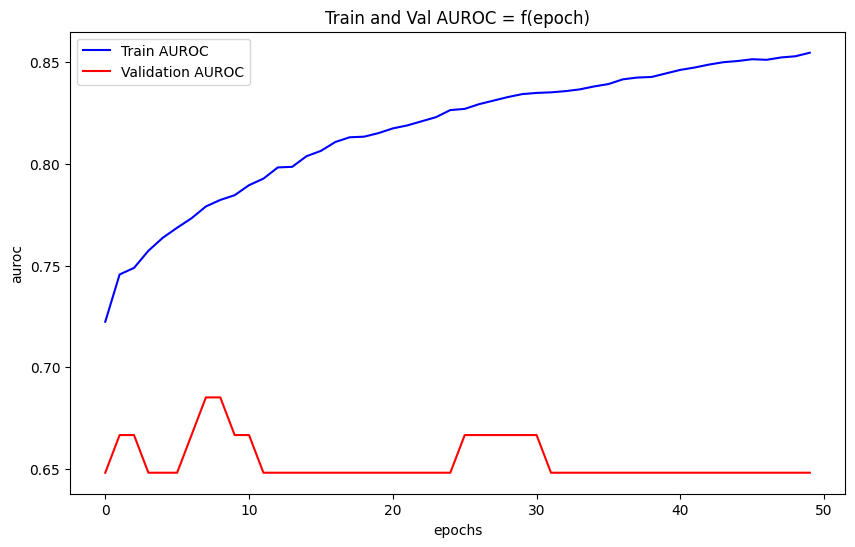

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:01<00:10,  1.15s/it]

test AUROC: 0.7963
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: nan


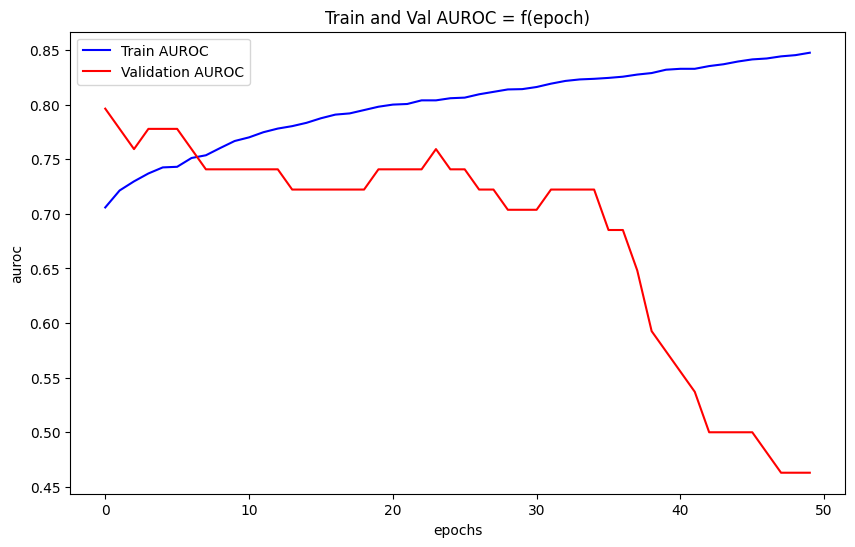

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:09,  1.13s/it]

test AUROC: 0.9286
test Precision: 0.1667
test Recall: 1.0000
test Specificity: 0.6000
test Accuracy: 0.6667
test F1 Score: 0.2857
test HL Score: nan


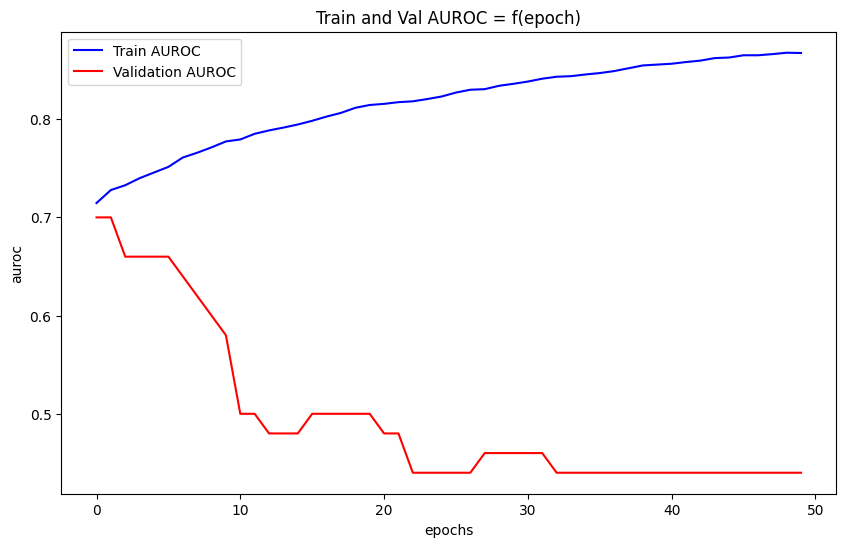

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.12s/it]

test AUROC: 0.8148
test Precision: 0.5556
test Recall: 0.8333
test Specificity: 0.4000
test Accuracy: 0.6667
test F1 Score: 0.6667
test HL Score: nan


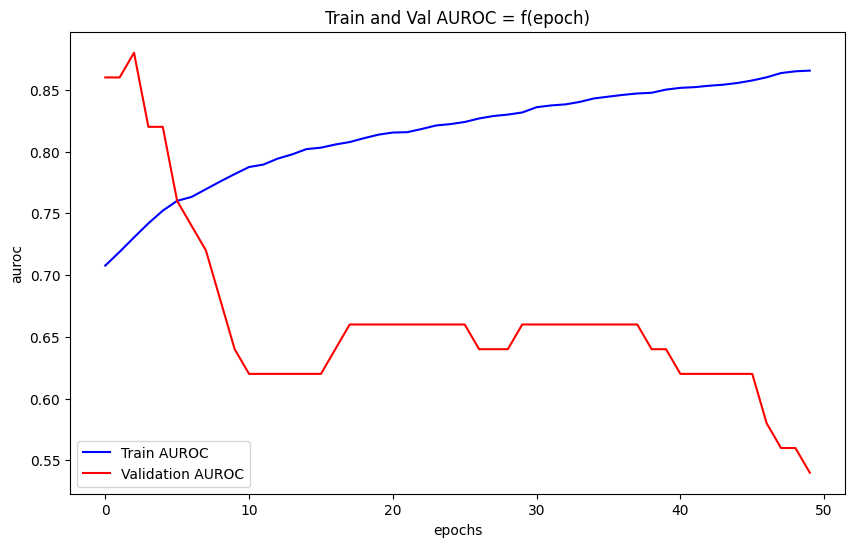

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.12s/it]

test AUROC: 0.6800
test Precision: 0.5000
test Recall: 0.6000
test Specificity: 0.6000
test Accuracy: 0.6667
test F1 Score: 0.5455
test HL Score: nan


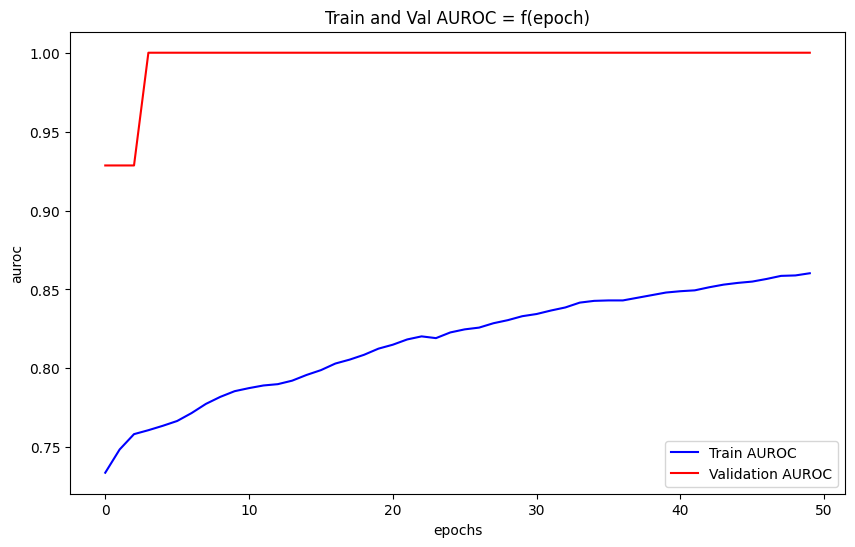

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.12s/it]

test AUROC: 0.5741
test Precision: 0.3750
test Recall: 0.5000
test Specificity: 0.4667
test Accuracy: 0.4667
test F1 Score: 0.4286
test HL Score: nan


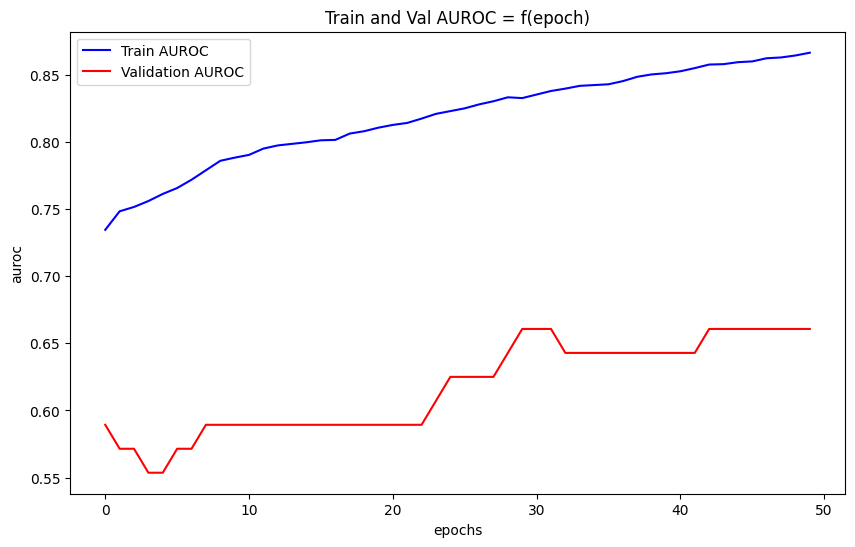

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.12s/it]/home/delmaire.c/miniconda3/envs/env0/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


test AUROC: 0.8200
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: nan


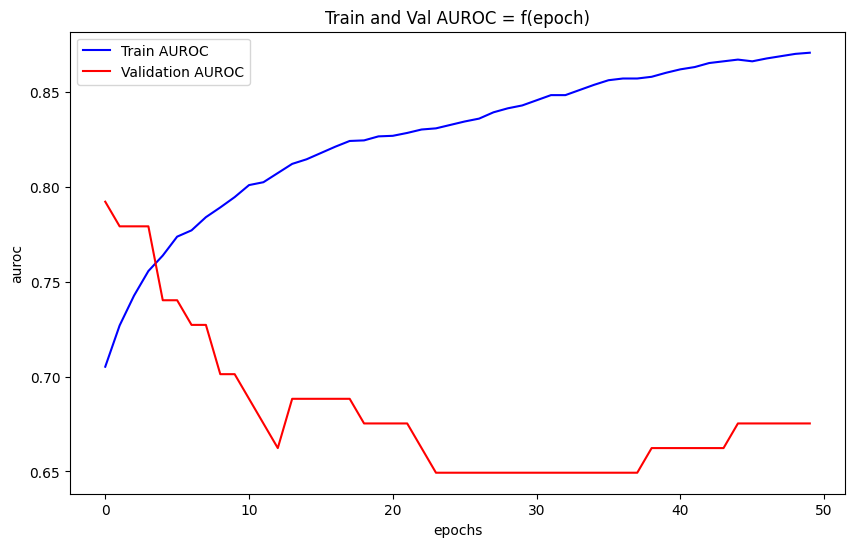

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.13s/it]

test AUROC: 0.8400
test Precision: 0.6250
test Recall: 1.0000
test Specificity: 0.4667
test Accuracy: 0.8000
test F1 Score: 0.7692
test HL Score: nan


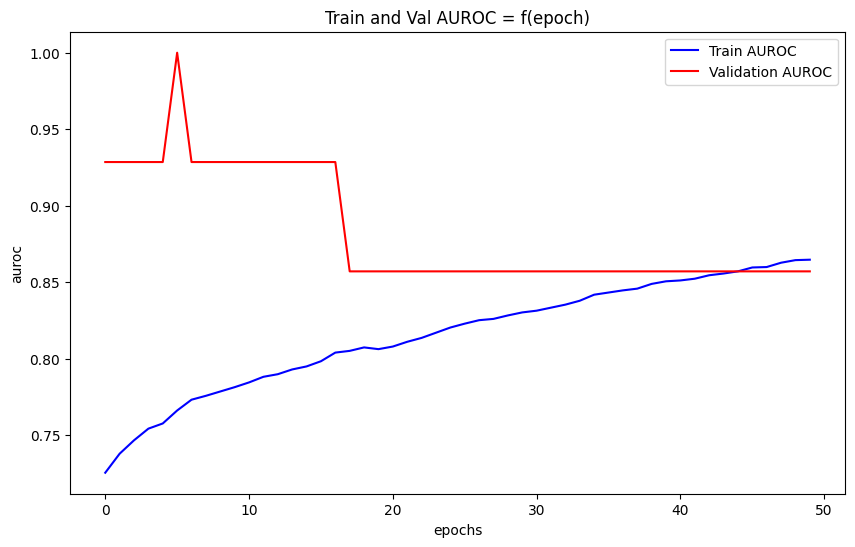

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:09<00:02,  1.13s/it]

test AUROC: 0.5536
test Precision: 0.6667
test Recall: 0.7500
test Specificity: 0.4000
test Accuracy: 0.6667
test F1 Score: 0.7059
test HL Score: nan


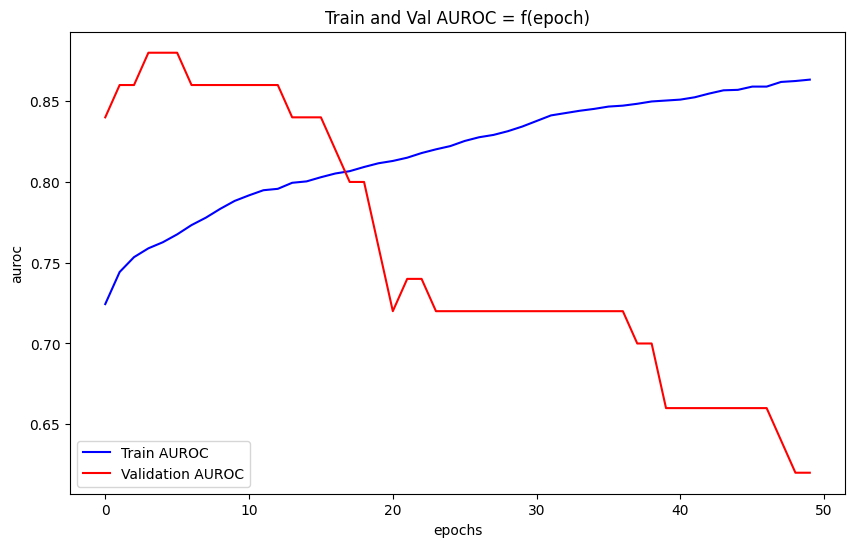

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:10<00:01,  1.12s/it]

test AUROC: 0.6852
test Precision: 0.4286
test Recall: 0.5000
test Specificity: 0.5333
test Accuracy: 0.5333
test F1 Score: 0.4615
test HL Score: nan


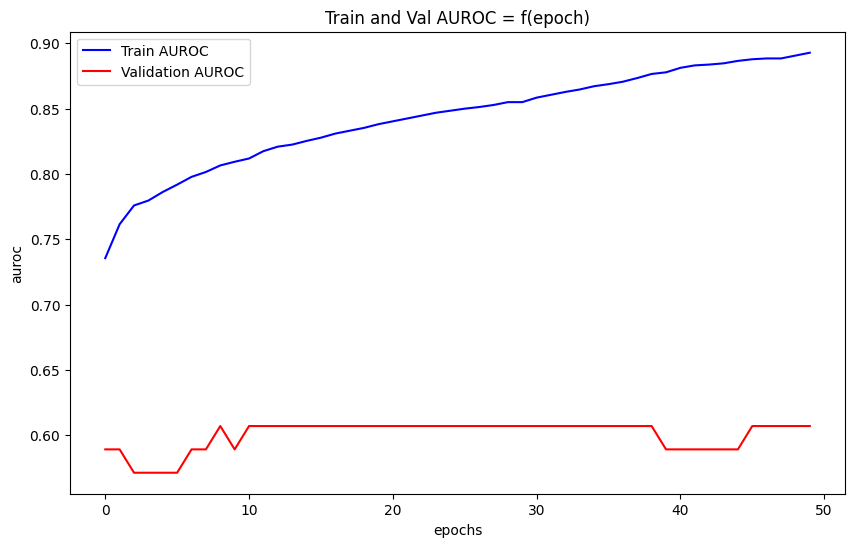

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 33%|█████████████████████████████████████████████████████▎                                                                                                          | 1/3 [00:11<00:22, 11.26s/it]

test AUROC: 0.7273
test Precision: 0.5556
test Recall: 0.7143
test Specificity: 0.5000
test Accuracy: 0.6667
test F1 Score: 0.6250
test HL Score: nan
Mean AUROC: 0.7420
Mean Precision: 0.4817
Mean Recall: 0.7531
Mean Specificity: 0.4700
Mean Accuracy: 0.6333
Mean F1 Score: 0.5684
SD Auroc: 0.1139



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

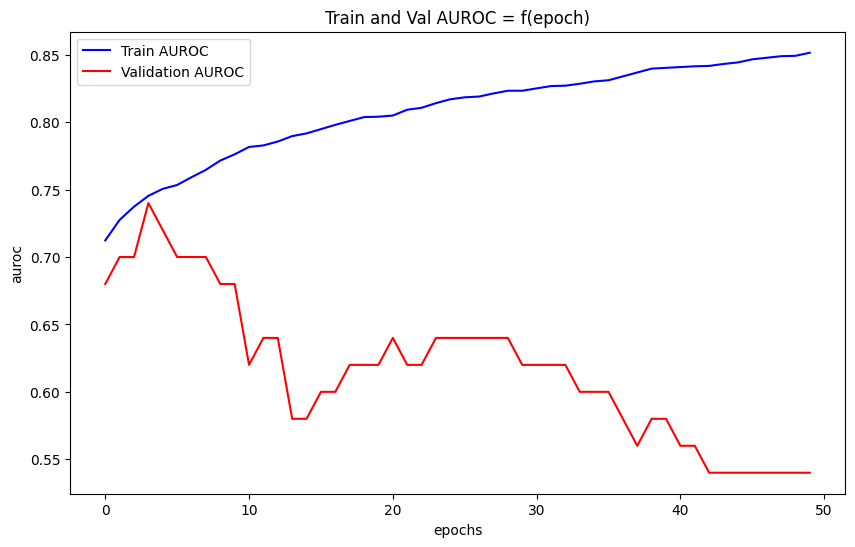

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:01<00:10,  1.12s/it]

test AUROC: 0.8333
test Precision: 0.6250
test Recall: 0.8333
test Specificity: 0.4667
test Accuracy: 0.7333
test F1 Score: 0.7143
test HL Score: nan


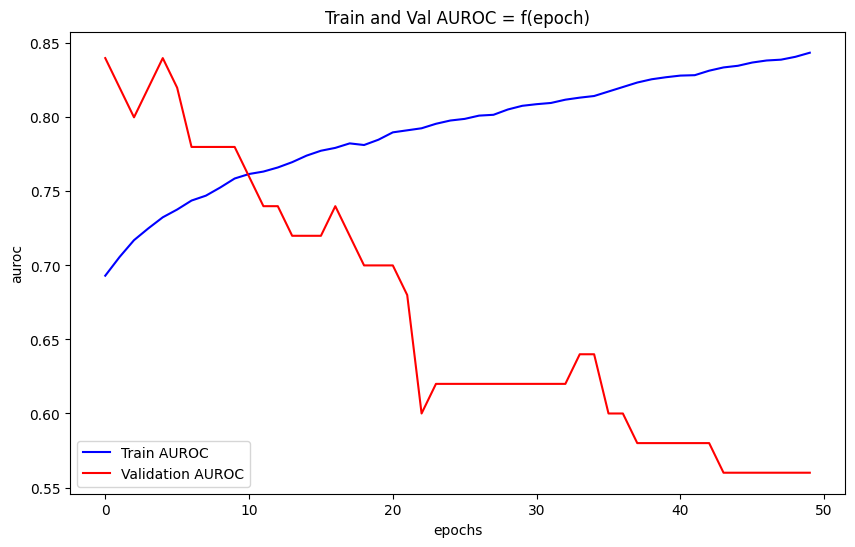

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:09,  1.24s/it]

test AUROC: 1.0000
test Precision: 0.1429
test Recall: 1.0000
test Specificity: 0.5333
test Accuracy: 0.6000
test F1 Score: 0.2500
test HL Score: nan


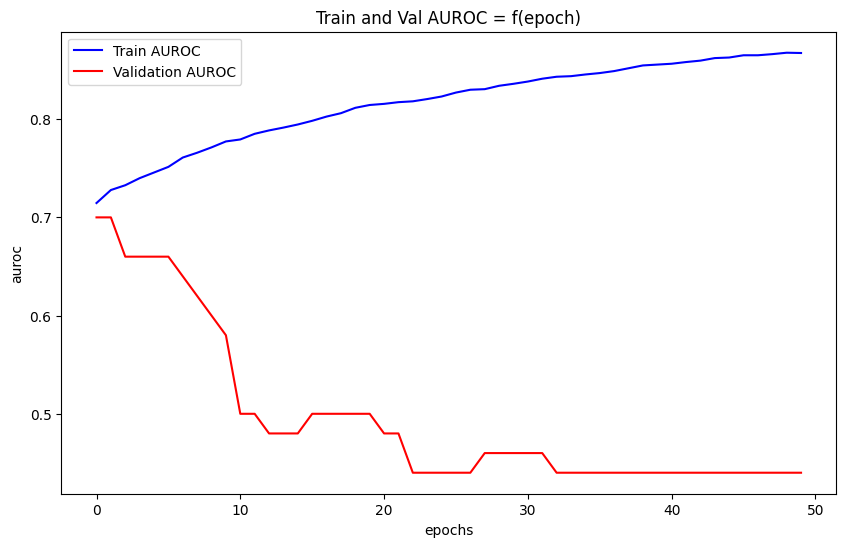

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:08,  1.18s/it]

test AUROC: 0.8148
test Precision: 0.5556
test Recall: 0.8333
test Specificity: 0.4000
test Accuracy: 0.6667
test F1 Score: 0.6667
test HL Score: nan


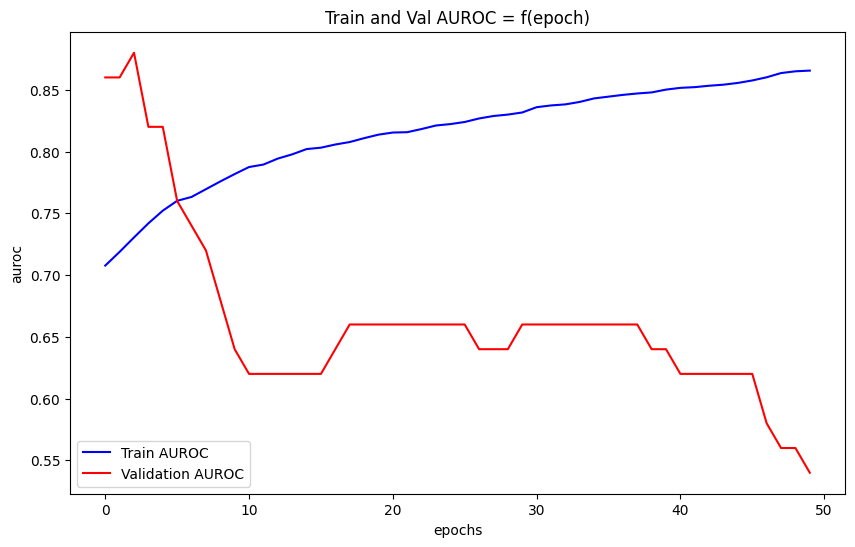

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.15s/it]

test AUROC: 0.6800
test Precision: 0.5000
test Recall: 0.6000
test Specificity: 0.6000
test Accuracy: 0.6667
test F1 Score: 0.5455
test HL Score: nan


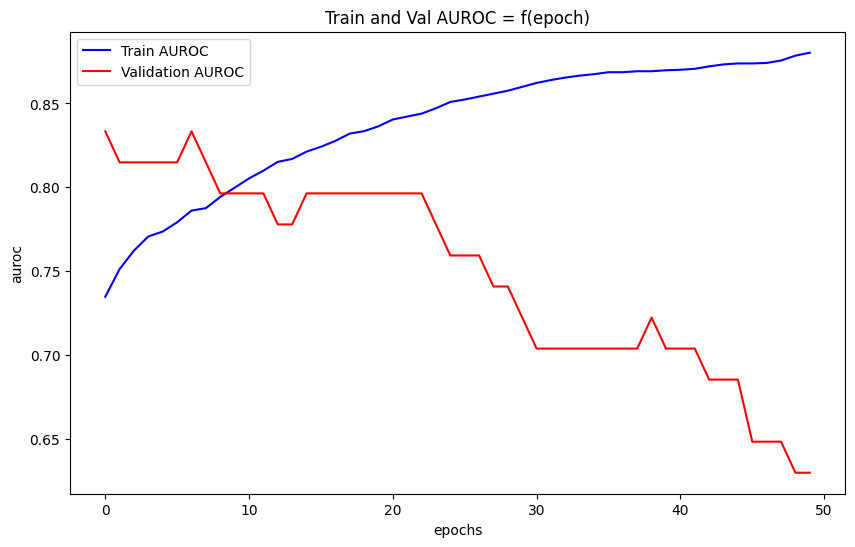

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.14s/it]

test AUROC: 0.5000
test Precision: 0.4286
test Recall: 0.5000
test Specificity: 0.5333
test Accuracy: 0.5333
test F1 Score: 0.4615
test HL Score: nan


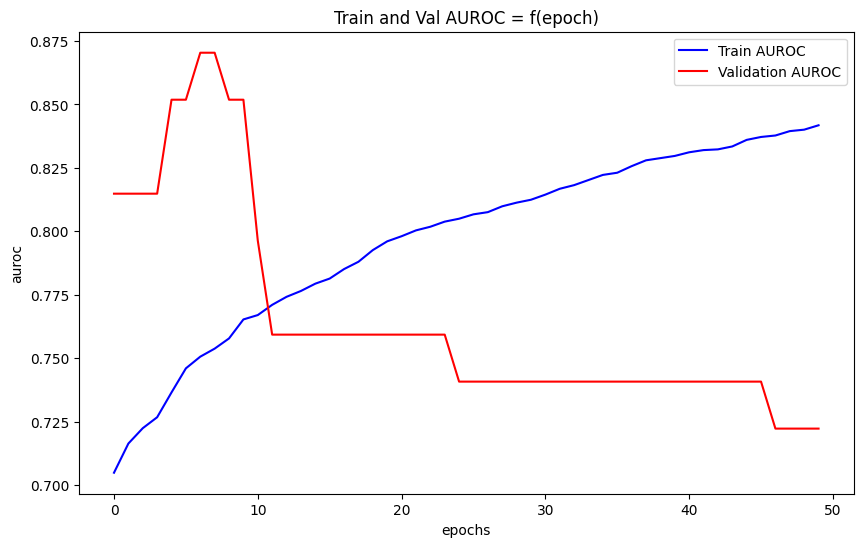

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.14s/it]

test AUROC: 0.8200
test Precision: 0.4000
test Recall: 0.8000
test Specificity: 0.3333
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: nan


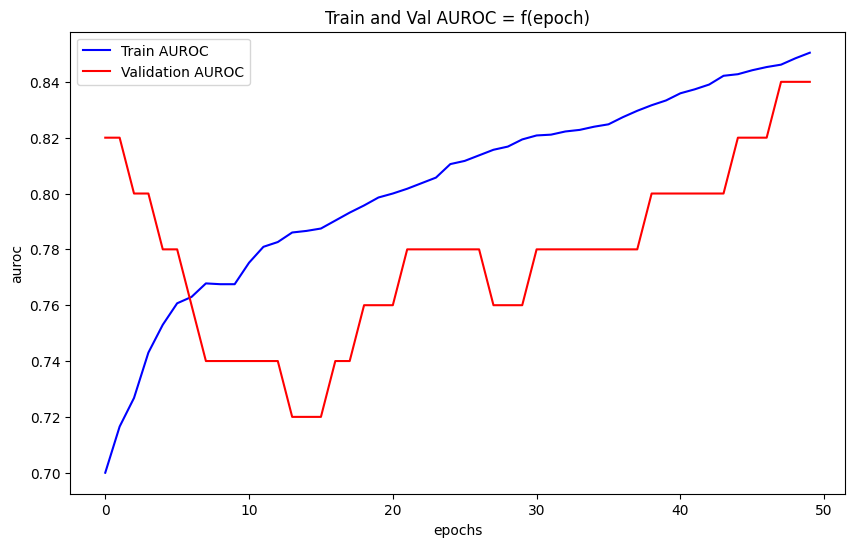

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:08<00:03,  1.13s/it]

test AUROC: 0.5600
test Precision: 0.2857
test Recall: 0.4000
test Specificity: 0.5333
test Accuracy: 0.4667
test F1 Score: 0.3333
test HL Score: nan


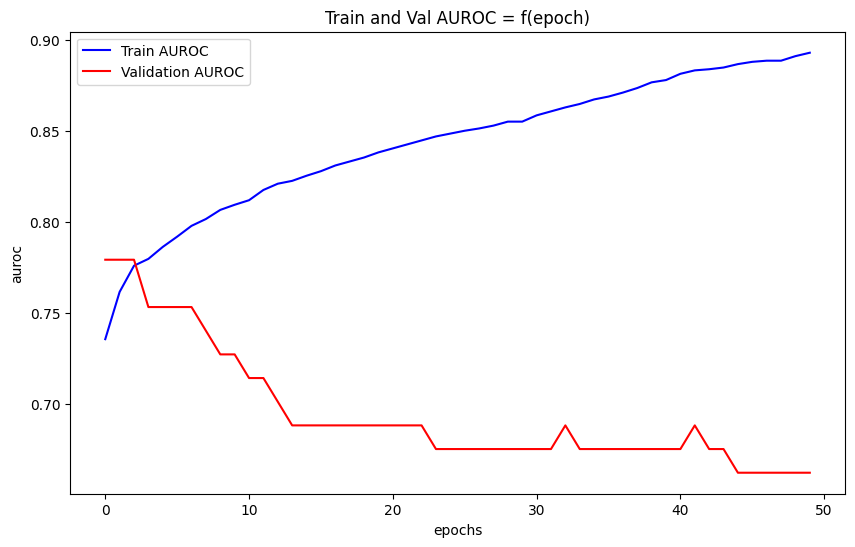

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:09<00:02,  1.13s/it]

test AUROC: 0.5893
test Precision: 0.6250
test Recall: 0.6250
test Specificity: 0.4667
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: nan


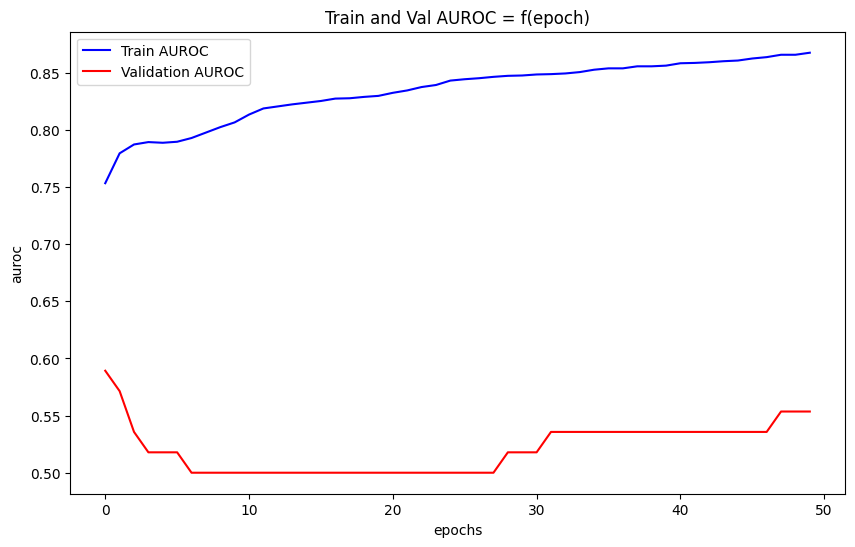

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:10<00:01,  1.12s/it]

test AUROC: 0.6667
test Precision: 0.4286
test Recall: 0.5000
test Specificity: 0.5333
test Accuracy: 0.5333
test F1 Score: 0.4615
test HL Score: nan


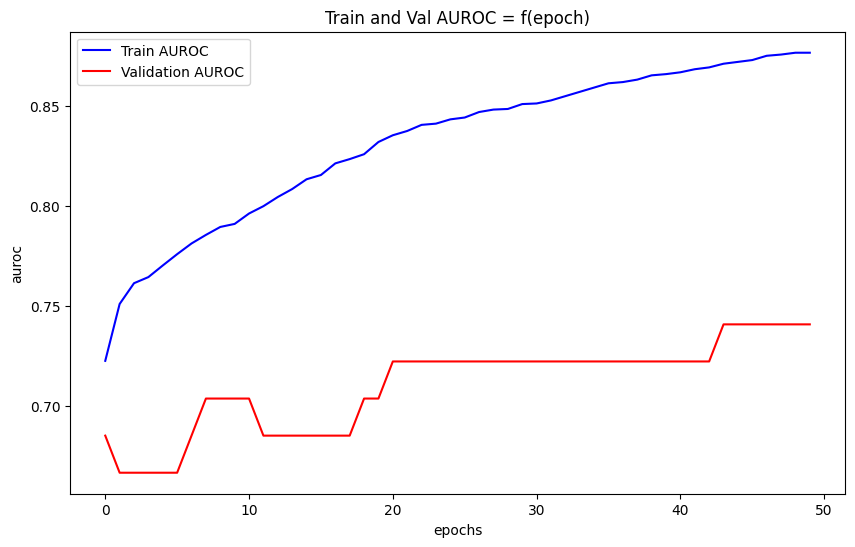

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2/3 [00:22<00:11, 11.33s/it]

test AUROC: 0.7013
test Precision: 0.6250
test Recall: 0.7143
test Specificity: 0.5556
test Accuracy: 0.7222
test F1 Score: 0.6667
test HL Score: nan
Mean AUROC: 0.7165
Mean Precision: 0.4616
Mean Recall: 0.6806
Mean Specificity: 0.4956
Mean Accuracy: 0.6056
Mean F1 Score: 0.5258
SD Auroc: 0.1435



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

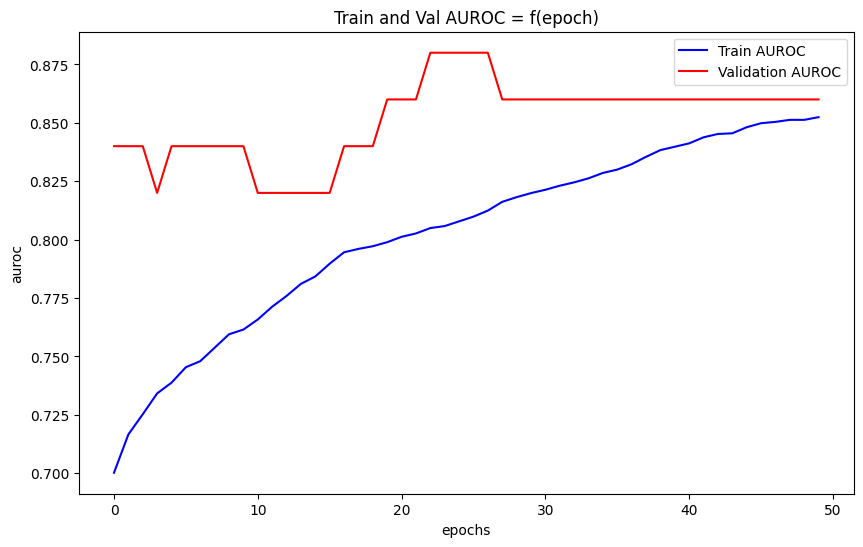

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:01<00:10,  1.13s/it]

test AUROC: 0.8519
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: nan


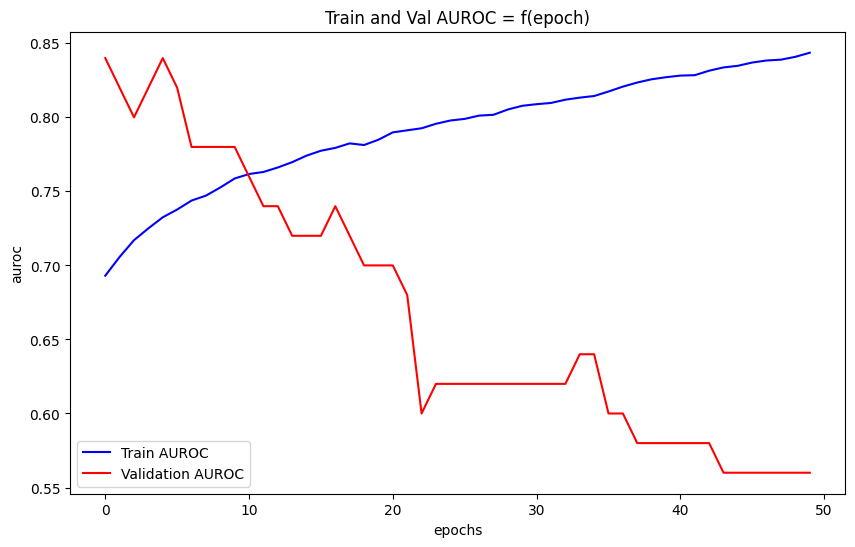

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.12s/it]

test AUROC: 1.0000
test Precision: 0.1429
test Recall: 1.0000
test Specificity: 0.5333
test Accuracy: 0.6000
test F1 Score: 0.2500
test HL Score: nan


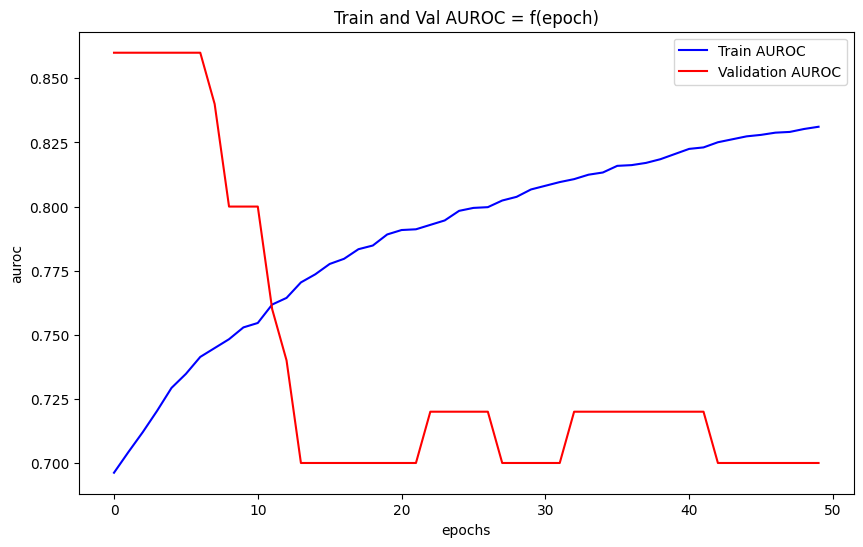

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.10s/it]

test AUROC: 0.8148
test Precision: 0.5556
test Recall: 0.8333
test Specificity: 0.4000
test Accuracy: 0.6667
test F1 Score: 0.6667
test HL Score: nan


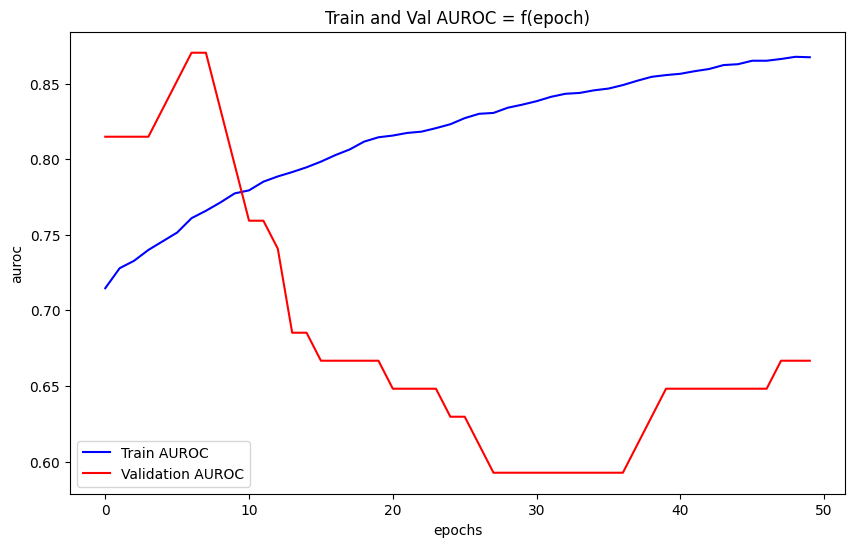

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.10s/it]

test AUROC: 0.6400
test Precision: 0.4286
test Recall: 0.6000
test Specificity: 0.5333
test Accuracy: 0.6000
test F1 Score: 0.5000
test HL Score: nan


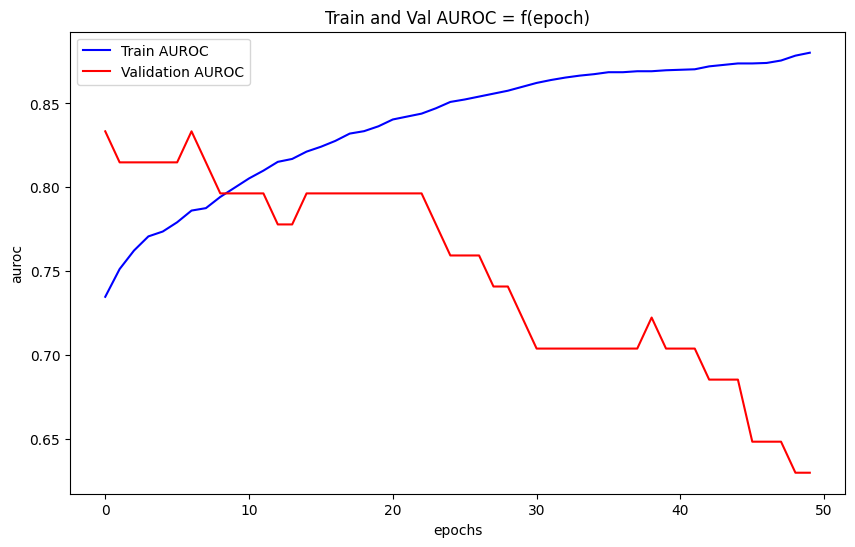

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.09s/it]

test AUROC: 0.5000
test Precision: 0.4286
test Recall: 0.5000
test Specificity: 0.5333
test Accuracy: 0.5333
test F1 Score: 0.4615
test HL Score: nan


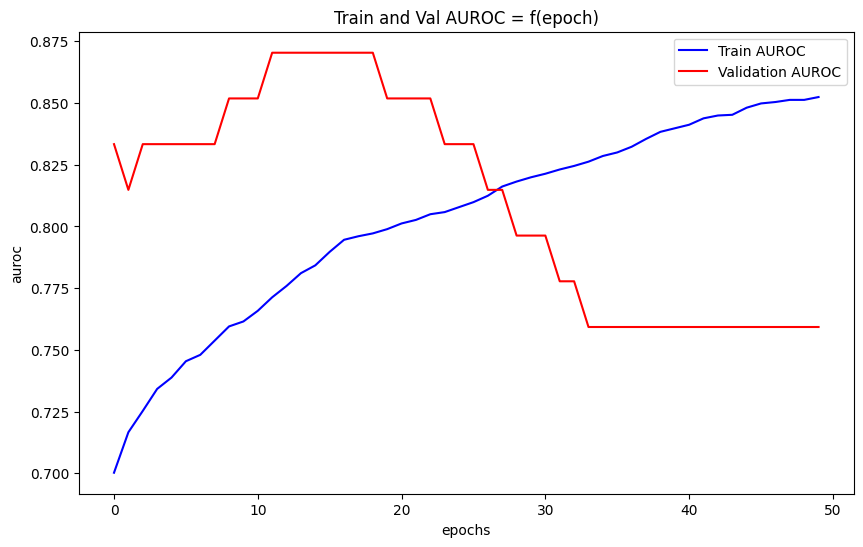

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.09s/it]

test AUROC: 0.8200
test Precision: 0.4545
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: nan


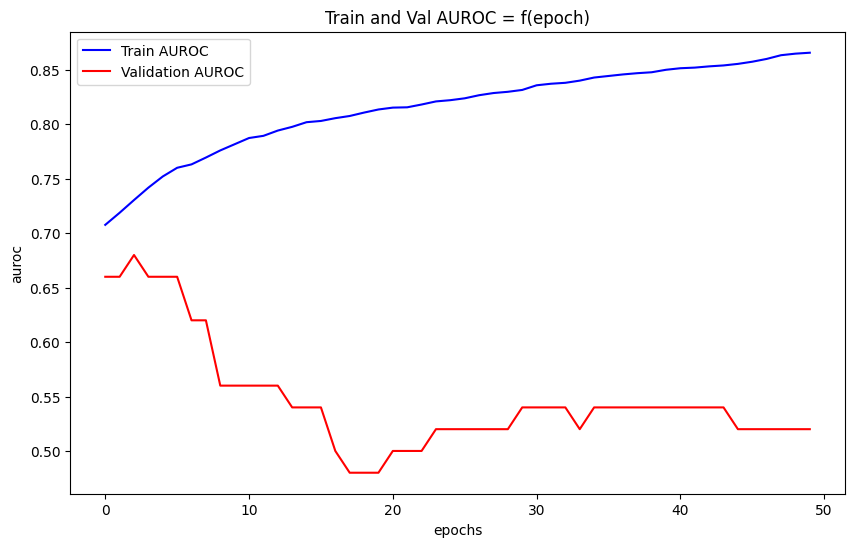

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.09s/it]

test AUROC: 0.8800
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.3333
test Accuracy: 0.6667
test F1 Score: 0.6667
test HL Score: nan


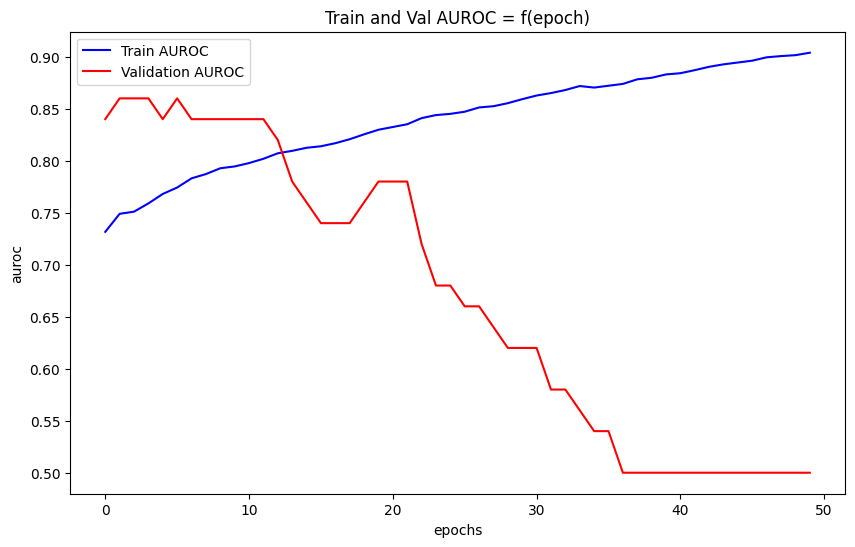

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:08<00:02,  1.09s/it]

test AUROC: 0.5714
test Precision: 0.6250
test Recall: 0.6250
test Specificity: 0.4667
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: nan


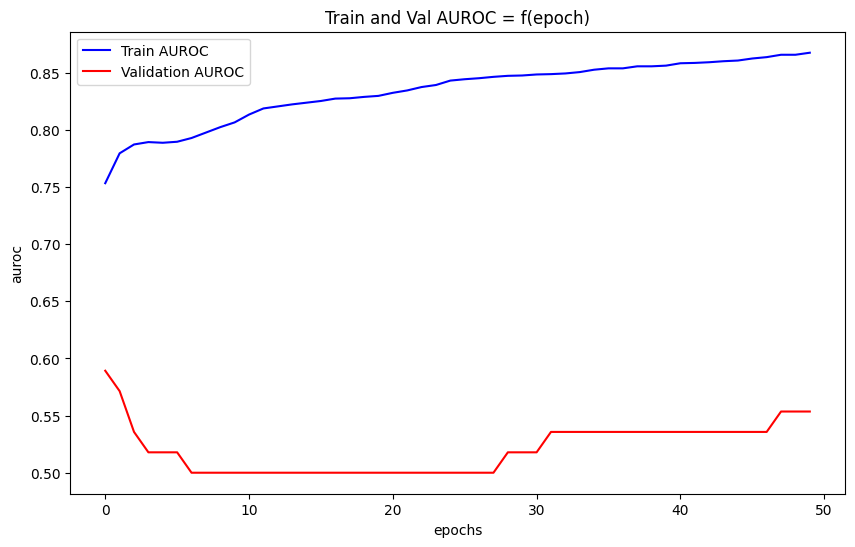

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:09<00:01,  1.09s/it]

test AUROC: 0.6667
test Precision: 0.4286
test Recall: 0.5000
test Specificity: 0.5333
test Accuracy: 0.5333
test F1 Score: 0.4615
test HL Score: nan


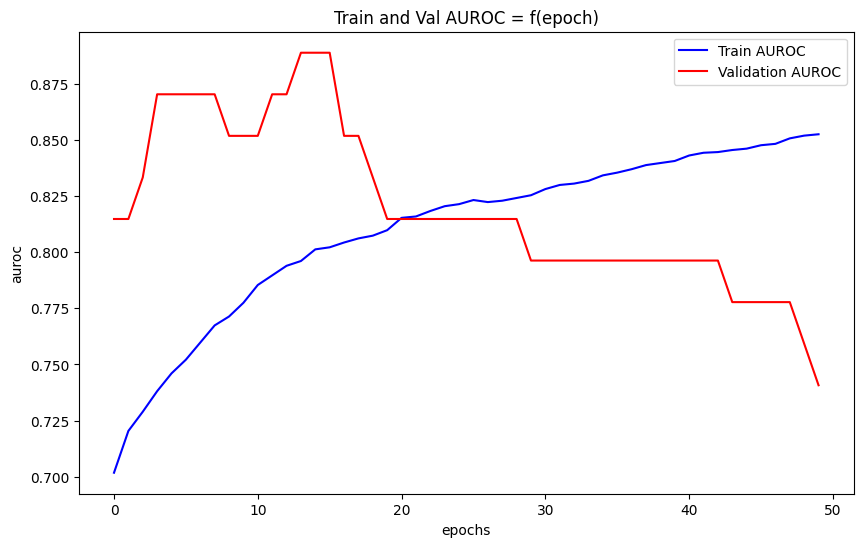

/tmp/ipykernel_34993/88422925.py:221: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.20s/it]

test AUROC: 0.7013
test Precision: 0.5000
test Recall: 0.7143
test Specificity: 0.4444
test Accuracy: 0.6111
test F1 Score: 0.5882
test HL Score: nan
Mean AUROC: 0.7446
Mean Precision: 0.4564
Mean Recall: 0.7773
Mean Specificity: 0.4244
Mean Accuracy: 0.6011
Mean F1 Score: 0.5511
SD Auroc: 0.1464
Total Mean AUROC: 0.7344
Total Mean Precision: 0.4666
Total Mean Recall: 0.7370
Total Mean Specificity: 0.4633
Total Mean Accuracy: 0.6133
Total Mean F1 Score: 0.5485


In [12]:
num_train = 3
K = 10

save_path = "saved_models/save1.pth"
load_path = "saved_models/test.pth"


best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_mean = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []   

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []    
    
    for j in tqdm(range(10)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, state_dict  =  train_model(data=data_ECMO,
                                                                                    target=target_ECMO,
                                                                                    test_fold = j,
                                                                                    validation_activated=True,
                                                                                    test_activated = True,
                                                                                    num_epochs=50, 
                                                                                    model_name="InceptionTime",
                                                                                    verbose=False, 
                                                                                    save_path=save_path, 
                                                                                    save_model=True, 
                                                                                    plot_train_curves = True,
                                                                                    load_model_path = load_path)
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        
        print(f"test AUROC: {auroc:.4f}")
        print(f"test Precision: {precision:.4f}")
        print(f"test Recall: {recall:.4f}")
        print(f"test Specificity: {tnr:.4f}")
        print(f"test Accuracy: {accuracy:.4f}")
        print(f"test F1 Score: {f1:.4f}")
        print(f"test HL Score: {HL_score:.4f}")
        # if best_val_auroc >= best_val_auroc_all_models:
        #     aurocs = [auroc]
        #     precisions = [precision]
        #     recalls = [recall]
        #     tnrs = [tnr]
        #     accuracies = [accuracy]
        #     f1s = [f1]
        #     best_val_auroc_all_models = best_val_auroc
        #     best_model_state_dict = state_dict
            
            # print(f"New best val_auroc: {best_val_auroc_all_models}")
    
        # print(f"Test AUROC with best model: {np.mean(aurocs):.4f}")
    
    print(f"Mean AUROC: {np.mean(aurocs):.4f}")
    print(f"Mean Precision: {np.mean(precisions):.4f}")
    print(f"Mean Recall: {np.mean(recalls):.4f}")
    print(f"Mean Specificity: {np.mean(tnrs):.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean F1 Score: {np.mean(f1s):.4f}")
    print(f"SD Auroc: {np.std(aurocs):.4f}")

    aurocs_mean.append(np.mean(aurocs))
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_mean):.4f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.4f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.4f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.4f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.4f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.4f}")